In [1]:
#!pip install optuna
#!pip install jupyterlab-optuna
#!pip install optuna-fast-fanova gunicorn
#!pip install imbalanced-learn
#!pip install hyperopt
#!pip install lightgbm
#!pip install catboost
#!pip install optuna-integration

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, log_loss, roc_auc_score, confusion_matrix, recall_score
from IPython.display import Markdown, display
from ipywidgets import widgets, Layout
from IPython import display as disp

# Define a function for printing using markdown
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

#Bold text delimiters
start_bold = "\033[1m"
end_bold = "\033[0;0m"

from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [3]:
#load the dataset and preview the first rows
df = pd.read_csv("./Data/diabetes.csv", sep = ",")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# EDA

In [4]:
#Verify that all columns have numeric types
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
#Check the target variable label values
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
#Get the summary sttistics for all the columns
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


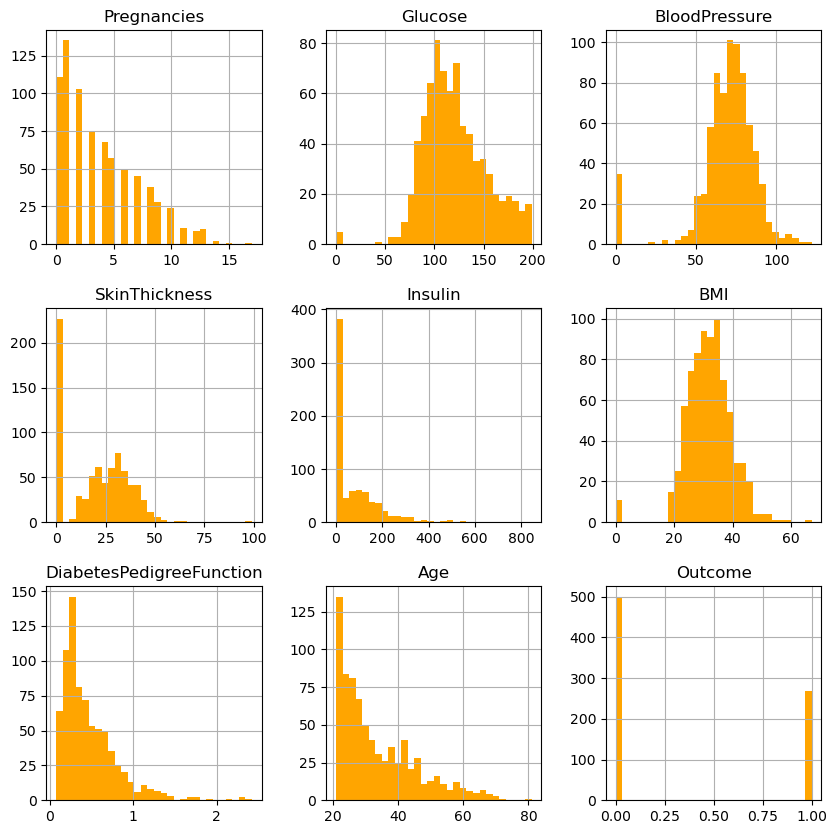

In [7]:
df.hist(bins = 30, figsize = (10, 10), color = 'orange')

plt.show()

Insights from the histograms:

* There are more young participants.
* Zero values for skin thickness, glucose, insulin, blood presure, and bmi indicate missing measurements. A glucose level of zero would mean the patient is in a coma or worse.
* There are about twice as many patients without diabetes (outcome = 0) than with diabetes (outcome = 1) resulting in unbalanced target classes.     

In [27]:
# Define a function to extract information about missing measurements 
def print_missing_data_summary(df):
    '''
    This function will scan for missing values for different features and feature combinations at different steps of the imputation process.

    Symbol dicionary:
    
    N_GLU - Number of missing Glucose measurements 
    N_INS - Number of missing Insulin measurements
    N_BMI - Number of missing BMI measurements
    N_BPS - Number of missing Blood Pressure measurements
    N_STH - Number of missing Skin Thickness measurements     
    '''
    def printmd(string, color=None):
        colorstr = "<span style='color:{}'>{}</span>".format(color, string)
        display(Markdown(colorstr))  
    
    display(Markdown('---'))
    printmd(f"**N_GLU**: {df['Glucose'].isna().sum()}", color="#9DC183")
    printmd(f"**N_INS**: {df['Insulin'].isna().sum()}", color="#9DC183")
    printmd(f"**N_BMI**: {df['BMI'].isna().sum()}", color="#9DC183")
    printmd(f"**N_BPS**: {df['BloodPressure'].isna().sum()}", color="#9DC183")
    printmd(f"**N_STH**: {df['SkinThickness'].isna().sum()}", color="#9DC183")
    display(Markdown('---'))    

def render_widgets(num_widgets, titles, objects):
    # Create output widgets
    widgets_list = [widgets.Output() for _ in range(num_widgets)]
    
    # Render content in output widgets
    for i in range(num_widgets):
        with widgets_list[i]:
            # Display title in bold format
            title_html = "<b>{}</b>".format(titles[i])
            disp.display(disp.HTML(title_html))
            disp.display(objects[i])
    
    # Add CSS styles to distribute free space
    box_layout = Layout(display='flex',
                        flex_flow='row',
                        justify_content='flex-start',
                        width='auto'
                       )
    
    # Create Horizontal Box container
    hbox = widgets.HBox(widgets_list, layout=box_layout)
    
    # Render hbox
    disp.display(hbox)

#Define a function to summarize the classification metrics
def print_classification_metrics(model, x_train, y_train, x_test, y_test):

    #Define pointers for bold text formatting
    start_bold = "\033[1m"
    end_bold = "\033[0m"
    
    #print(start_bold + "Classification metrics" + end_bold)
    print()

    # performance of the trained model on the training set 
    train_result = model.score(x_train, y_train)

    # performance of the trained model using the testing set
    test_result = model.score(x_test, y_test)

    # make predictions on the training data
    y_train_predict = model.predict(x_train)     

    # make predictions on the test data
    y_predict = model.predict(x_test)

    # predict class probabilities on the training set
    y_train_predict_proba = model.predict_proba(x_train)

    # predict class probabilities on the test set
    y_predict_proba = model.predict_proba(x_test)

    # Calculate log loss for the training set
    log_loss_train = round(log_loss(y_train, y_train_predict_proba), 4)
    
    # Calculate log loss for the test set
    log_loss_value = round(log_loss(y_test, y_predict_proba), 4)

    # Calculate ROC AUC for the training set    
    roc_auc_train = roc_auc_score(y_train, y_train_predict_proba[:, 1])

    # Calculate ROC AUC for the test set    
    roc_auc = roc_auc_score(y_test, y_predict_proba[:, 1])

    # Calculate Precision-Recall score for the TRAINING set
    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_predict_proba[:, 1])

    # Define recall levels for interpolation
    recall_levels = np.linspace(0, 1, 100)

    # Interpolate precision values for each recall level
    interp_precision_train = np.interp(recall_levels, recall_train[::-1], precision_train[::-1])

    # Calculate AUPRC using the trapezoidal rule
    auprc_train = np.trapz(interp_precision_train, recall_levels)    
    
    # Calculate Precision-Recall score for the TEST set
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_predict_proba[:, 1])

    # # Define recall levels for interpolation
    # recall_levels = np.linspace(0, 1, 100)

    # Interpolate precision values for each recall level
    interp_precision_test = np.interp(recall_levels, recall_test[::-1], precision_test[::-1])

    # Calculate AUPRC using the trapezoidal rule
    auprc_test = np.trapz(interp_precision_test, recall_levels)    

    # train_report = pd.DataFrame(classification_report(y_train, 
    #                                                   y_train_predict,
    #                                                   digits=4,
    #                                                   output_dict = True)).transpose().astype(float).round(4).map("{:,.2f}".format)
    
    test_report = pd.DataFrame(classification_report(y_test,
                                                     y_predict,
                                                     digits=4,
                                                     output_dict = True)).transpose().astype(float).round(4).map("{:,.2f}".format)    
    
    add_test_metrics = pd.DataFrame([{'Log Loss': log_loss_value,
                                     'ROC AUC': round(roc_auc, 4),
                                     'AUPRC': round(auprc_test, 4)}], columns = ['Log Loss',
                                                                                 'ROC AUC',
                                                                                 'AUPRC']).transpose().rename(columns = {0: 'Test Score'})

    titles = ['Test set performance', 'Additional metrics(Log Loss, ROC Curve, Precission-Recall)']
    render_widgets(2, titles, [test_report, add_test_metrics])

    # add_train_metrics = pd.DataFrame([{'Log Loss': log_loss_train,
    #                                   'ROC AUC': round(roc_auc_train, 4),
    #                                   'AUPRC': round(auprc_train, 4)}], columns = ['Log Loss',
    #                                                                                'ROC AUC',
    #                                                                                'AUPRC']).transpose().rename(columns = {0: 'Train Score'})
    
    

    # titles = ['Additional metrics', '(Log Loss, ROC Curve, Precission-Recall)']
    # render_widgets(2, titles, [add_train_metrics, add_test_metrics])

    # # print the confusion matrix
    # cm = confusion_matrix(y_test, y_predict)

    # sns.set_context('talk')

    # sns.heatmap(cm, fmt = 'd', annot = True, cmap = 'RdGy')    

    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_predict)

    # Set the labels for the confusion matrix
    class_labels = ['Negative', 'Positive']  # Replace with your actual class labels
    
    # Create a heatmap with labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdGy', xticklabels=class_labels, yticklabels=class_labels)
    
    # Add labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(left=0.2, bottom=0.2)
    
    # Show the plot
    plt.show()

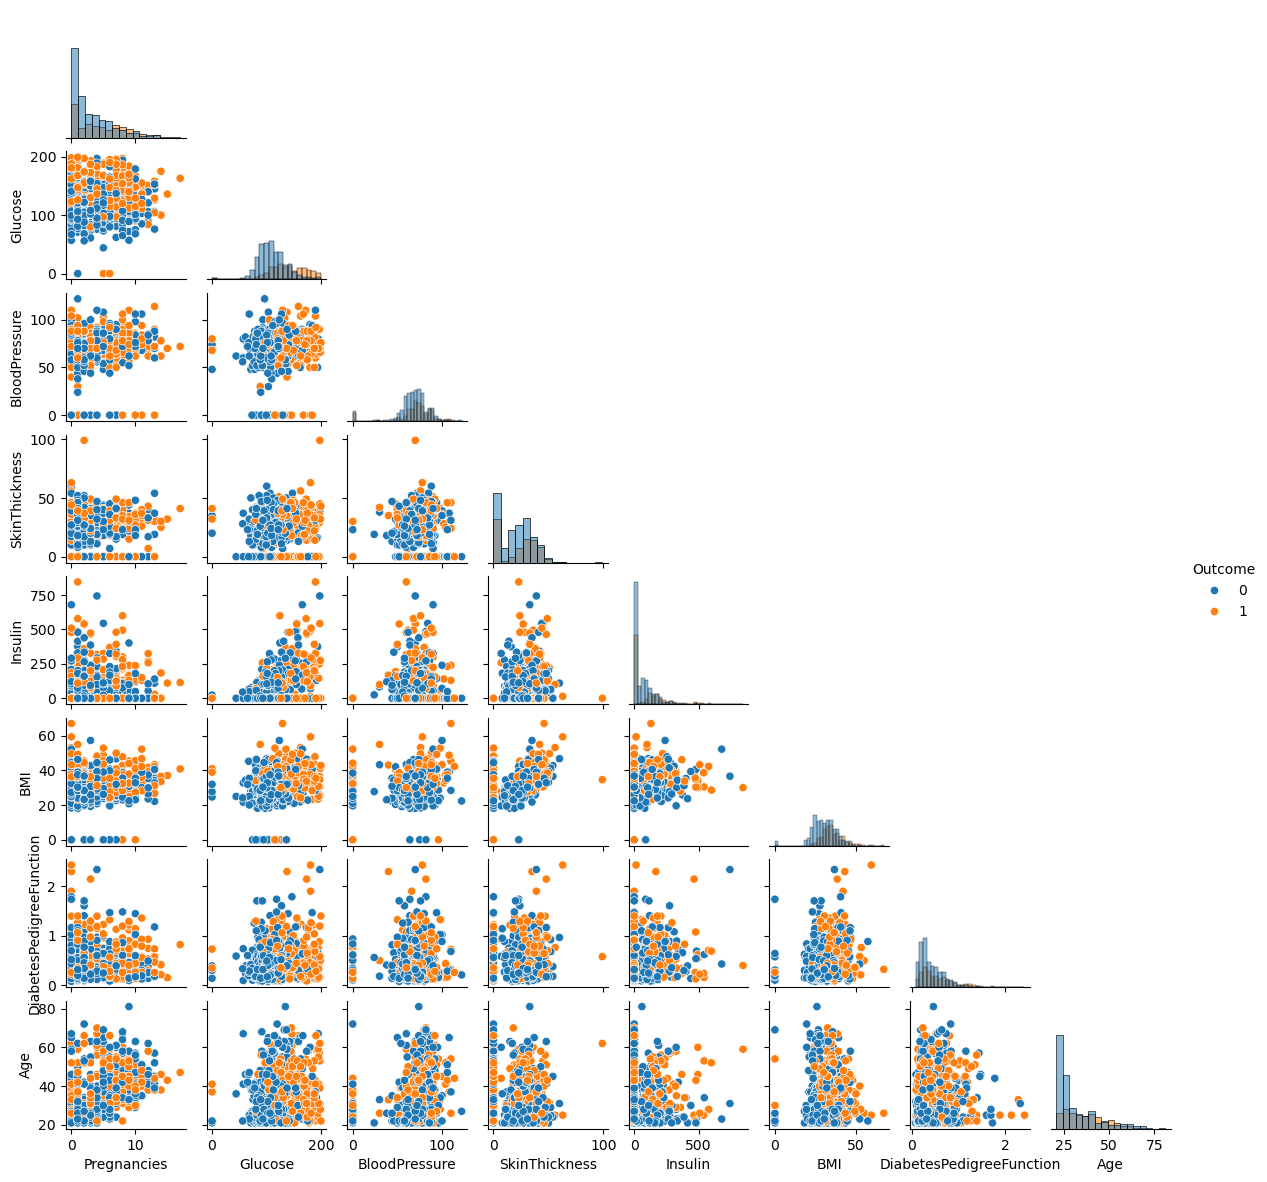

In [9]:
# # Create a correlation matrix
# corr_matrix = df.corr()

# # Plot the correlation matrix
# sns.set_context('talk')

# plt.figure(figsize = (10, 10))

# _ = sns.heatmap(corr_matrix, annot = True, fmt = ".3f", linewidths = .5)

# plt.show()

sns.pairplot(df, hue = 'Outcome', height = 1.5, corner = True, kind = 'scatter', diag_kind = 'hist')

In [10]:
cols = ["Glucose","Insulin","BMI","BloodPressure","SkinThickness"]
df[cols] = df[cols].replace({0: np.nan})

print_missing_data_summary(df)

---

<span style='color:#9DC183'>**N_GLU**: 5</span>

<span style='color:#9DC183'>**N_INS**: 374</span>

<span style='color:#9DC183'>**N_BMI**: 11</span>

<span style='color:#9DC183'>**N_BPS**: 35</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

In [11]:
# split the dataframe into target and features

y = df["Outcome"].copy() # target
X = df.drop(columns = ["Outcome"]).copy() # features

# Verify that the split was performed correctly
print(X.shape)
print(y.shape)

(768, 8)
(768,)


In [12]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy = False)

cols = ["Glucose", "BMI", "BloodPressure"]
X[cols] = imp_mean.fit_transform(X[cols])

print_missing_data_summary(X)

---

<span style='color:#9DC183'>**N_GLU**: 0</span>

<span style='color:#9DC183'>**N_INS**: 374</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

In [13]:
cols = ["Glucose", "Insulin"]

y_train_imp = X[cols[1]].dropna()
X_train_imp = X.loc[y_train_imp.index, cols[0]].values.reshape(-1, 1)

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

# Define the search space for hyperparameters
space = {
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype = int)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)),
    'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, dtype = int)),
    'num_leaves': hp.choice('num_leaves', np.arange(10, 65, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'min_child_samples': hp.choice('min_child_samples', np.arange(5, 101, dtype = int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 1e-8, 1.0),    
    
    
}

# Define the objective function to minimize (e.g., mean squared error)
def objective(params):
    # Instantiate a Gradient Boosting Regressor with the specified hyperparameters
    gb_imputer = XGBRegressor(
        objective = 'reg:squarederror',
        max_depth = int(params['max_depth']),
        n_estimators = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        min_child_weight = int(params['min_child_weight']),        
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda'],                        
        seed = 21,
        n_jobs = -1,                
        verbosity = 0,       
    )

    score = cross_val_score(gb_imputer,
                            X_train_imp,
                            y_train_imp,
                            cv=5,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1)
    
    return {'loss': -score.mean(), 'status': STATUS_OK}    
    
# Run hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials,
            rstate=np.random.default_rng(21)
           )

# Get the best hyperparameters
best_params = space_eval(space, best)

# Instantiate a Gradient Boosting Regressor with the best hyperparameters
gb_imputer = XGBRegressor(**best_params,
                           seed = 21,
                           n_jobs = -1,                           
                           verbosity = 0,                           
                           )

# Fit the imputer on your data
gb_imputer.fit(X_train_imp, y_train_imp)

y_missing_idx = X[cols[1]].isna()
X_new = X.loc[y_missing_idx, cols[0]].values.reshape(-1, 1)

# Predict missing values
y_predict = gb_imputer.predict(X_new)

# Update the original DataFrame with predicted values
X.loc[y_missing_idx, cols[1]] = y_predict

print_missing_data_summary(X)

100%|███████| 100/100 [00:37<00:00,  2.68trial/s, best loss: 100.83567724283948]


---

<span style='color:#9DC183'>**N_GLU**: 0</span>

<span style='color:#9DC183'>**N_INS**: 0</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

In [14]:
cols = ["BMI", "SkinThickness"]

y_train_imp = X[cols[1]].dropna()
X_train_imp = X.loc[y_train_imp.index, cols[0]].values.reshape(-1, 1)

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

# Define the search space for hyperparameters
space = {
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype = int)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)),
    'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, dtype = int)),
    'num_leaves': hp.choice('num_leaves', np.arange(10, 65, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'min_child_samples': hp.choice('min_child_samples', np.arange(5, 101, dtype = int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 1e-8, 1.0),     
}

# Define the objective function to minimize (e.g., mean squared error)
def objective(params):
    # Instantiate a Gradient Boosting Regressor with the specified hyperparameters
    gb_imputer = XGBRegressor(
        objective = 'reg:squarederror',
        max_depth = int(params['max_depth']),
        n_estimators = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        min_child_weight = int(params['min_child_weight']),        
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda'],                        
        seed = 21,                    
        verbosity = 0,       
    )

    score = cross_val_score(gb_imputer,
                            X_train_imp,
                            y_train_imp,
                            cv=5,
                            scoring='neg_root_mean_squared_error',
                            )
    
    return {'loss': -score.mean(), 'status': STATUS_OK}    
    
# Run hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials,
            rstate=np.random.default_rng(21)
           )

# Get the best hyperparameters
best_params = space_eval(space, best)

# Instantiate a Gradient Boosting Regressor with the best hyperparameters
gb_imputer = XGBRegressor(**best_params,
                           seed = 21,                                                
                           verbosity = 0,                                                      
                           )

# Fit the imputer on your data
gb_imputer.fit(X_train_imp, y_train_imp)

y_missing_idx = X[cols[1]].isna()
X_new = X.loc[y_missing_idx, cols[0]].values.reshape(-1, 1)

# Predict missing values
y_predict = gb_imputer.predict(X_new)

# Update the original DataFrame with predicted values
X.loc[y_missing_idx, cols[1]] = y_predict

print_missing_data_summary(X)

100%|███████| 100/100 [02:32<00:00,  1.53s/trial, best loss: 7.9809844064657565]


---

<span style='color:#9DC183'>**N_GLU**: 0</span>

<span style='color:#9DC183'>**N_INS**: 0</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 0</span>

---

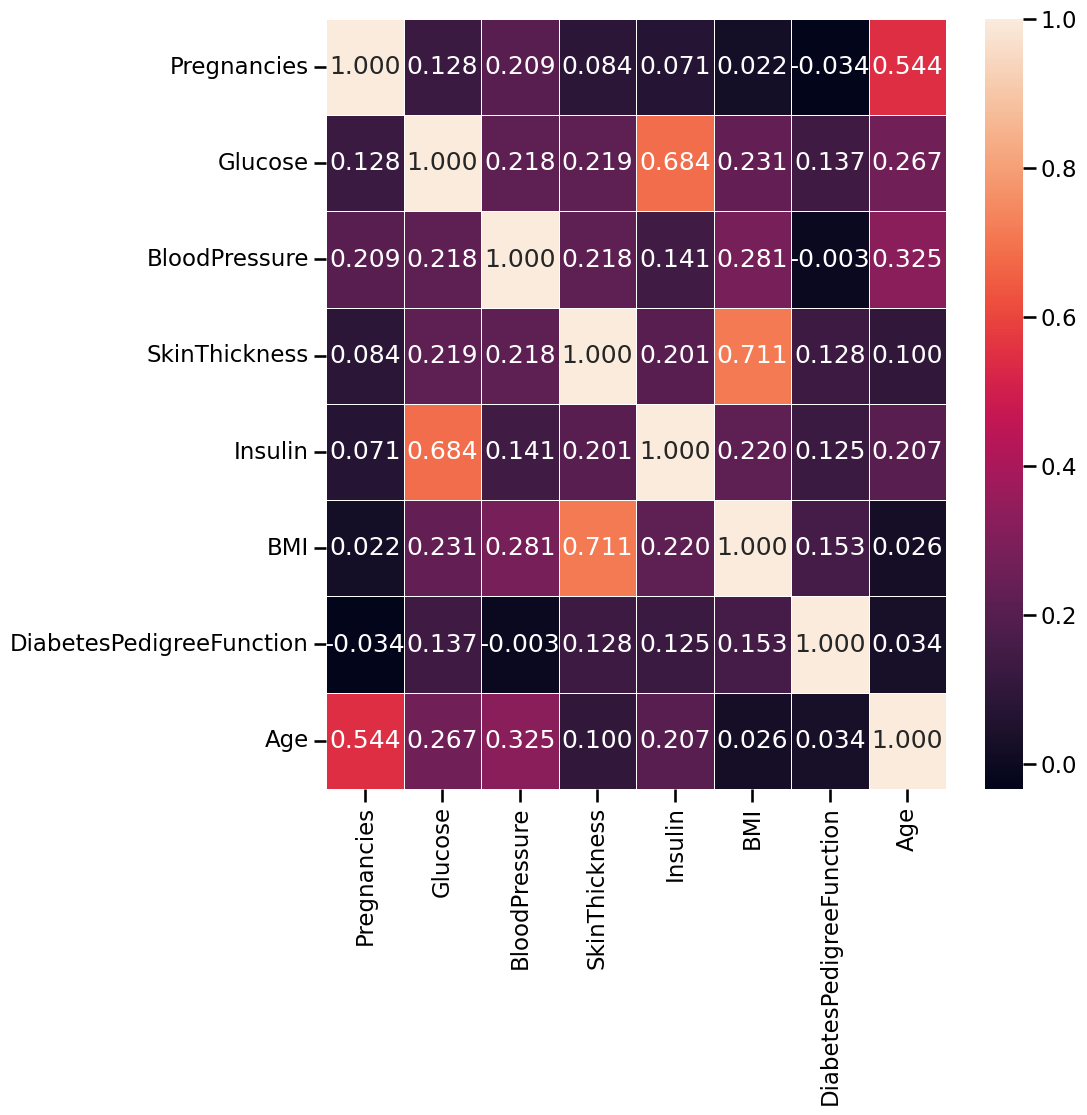

In [15]:
# Create a correlation matrix
corr_matrix = X.corr()

# Plot the correlation matrix
sns.set_context('talk')

plt.figure(figsize = (10, 10))

_ = sns.heatmap(corr_matrix, annot = True, fmt = ".3f", linewidths = .5)

plt.show()

In [16]:
df1 = df.dtypes
df2 = X.dtypes


titles = ['Original dtypes', 'New dtypes' ]
render_widgets(2, titles, [df1, df2])

In [17]:
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age']

X[cols] = X[cols].astype(int)

X.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

In [18]:
# sns.pairplot(X, 
#              #hue = 'Outcome',
#              kind = 'scatter',
#              diag_kind = 'hist')

In [19]:
from collections import Counter

counter = Counter(y)
print(counter)

Counter({0: 500, 1: 268})


In [20]:
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.866


In [21]:
# split the labels and features into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 21, stratify = y)

# Verify that the split was performed correctly
print('Training set')
print(X_train.shape)
print(y_train.shape)
print()
print('Testing set')
print(X_test.shape)
print(y_test.shape)
print()

Training set
(514, 8)
(514,)

Testing set
(254, 8)
(254,)



In [22]:
# Verify that the index has been shuffled
print(X.index)
print()
print(X_train.index)

RangeIndex(start=0, stop=768, step=1)

Index([341, 695, 387, 528, 619, 195, 700, 581, 579, 131,
       ...
       570, 107, 588,   2, 355,  96, 544, 508, 470, 727],
      dtype='int64', length=514)


In [23]:
X_train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Create a StandardScaler object
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

# Transform the test data (using the same scaling parameters as the training data)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

display(pd.DataFrame(X_train_scaled).head())

print()

display(X_train.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.071429,0.271429,0.523810,0.152174,0.070913,0.154004,0.254056,0.250000
1,0.500000,0.607143,0.714286,0.184783,0.560096,0.246407,0.021349,0.366667
2,0.571429,0.342857,0.833333,0.315217,0.135817,0.511294,0.068745,0.400000
3,0.000000,0.428571,0.428571,0.260870,0.209135,0.254620,0.177199,0.016667
4,0.000000,0.442857,0.500000,0.195652,0.137019,0.287474,0.026900,0.050000


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
341,1,95,74,21,73,25.9,0.673,36
695,7,142,90,24,480,30.4,0.128,43
387,8,105,100,36,127,43.3,0.239,45
528,0,117,66,31,188,30.8,0.493,22
619,0,119,72,25,128,32.4,0.141,24


# Train a base XGBoost Classifier on the dataset

In [25]:
#Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss', 
                               scale_pos_weight = 1.866,
                               )
#Train the model
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Test the model

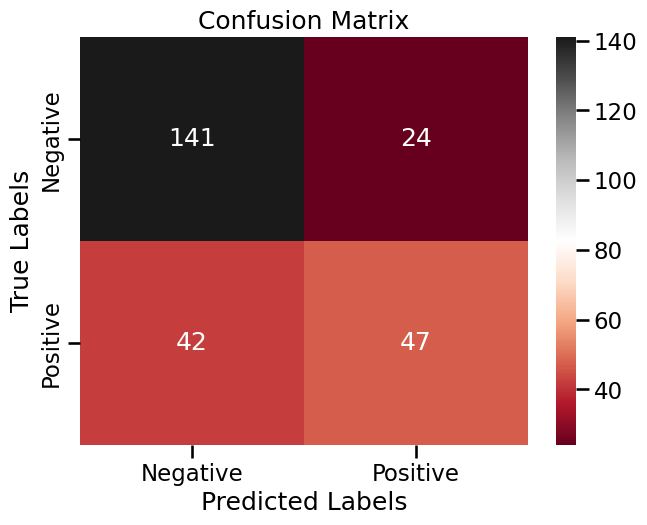

In [28]:
print_classification_metrics(xgb_classifier, X_train, y_train, X_test, y_test)

## Re-train the model on the scaled set

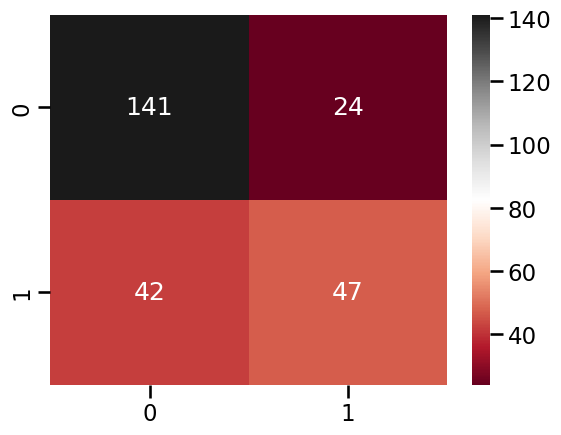

In [27]:
#Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss',
                               scale_pos_weight = 1.866,
                               )

xgb_classifier.fit(X_train_scaled, y_train)

# predict the performance score of the trained model using the testing dataset
print_classification_metrics(xgb_classifier, X_train_scaled, y_train, X_test_scaled, y_test)

* For the XGBoost (tree-based) classifier wich is robust to feature scales, scaling is not particularly significant as shown by the scores above. The only improvement over the unscaled set is one less false positive as shown by the confusion matrix.   

## Re-train the model on the "raw" data

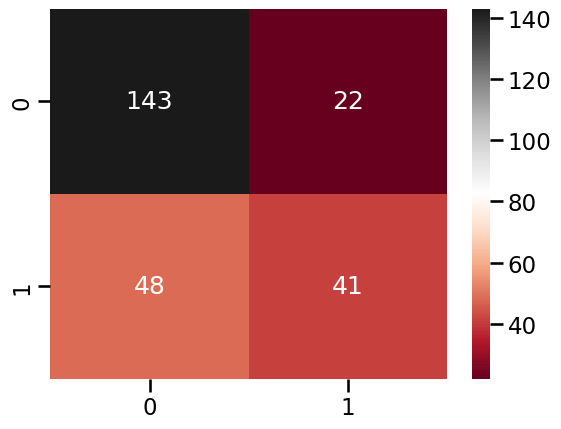

In [28]:
# Reload the unprocessed dataset
df_raw = pd.read_csv("./Data/diabetes.csv", sep = ",")

# split the unprocessed data into target and features

y_raw = df_raw["Outcome"] # target
X_raw = df_raw.drop(columns = ["Outcome"]) # features

# split the data into train and test sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size = 0.33, random_state = 21, stratify = y_raw)

#Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss', 
                               scale_pos_weight = 1.866,
                               )

#Fit the classifier to the raw data
xgb_classifier.fit(X_train_raw, y_train_raw)

# predict the performance score of the trained model using the testing dataset
print_classification_metrics(xgb_classifier, X_train_raw, y_train_raw, X_test_raw, y_test_raw)

In [29]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(sampling_strategy = 'minority',
           random_state = 21,
           k_neighbors = 6,
           )

X_res, y_res = sm.fit_resample(X_train_scaled, y_train)
print()
print('Original dataset shape %s' % Counter(y_train))
print()
print('Resampled dataset shape %s' % Counter(y_res))
print()


Original dataset shape Counter({0: 335, 1: 179})

Resampled dataset shape Counter({0: 335, 1: 335})



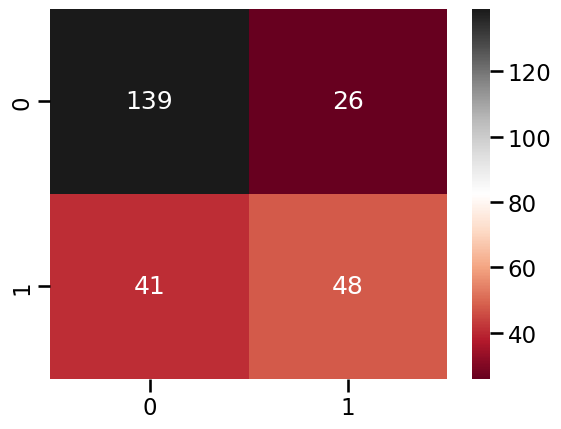

In [30]:
#Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss',                            
                               )

#Fit the classifier to the raw data
xgb_classifier.fit(X_res, y_res)

# predict the performance score of the trained model using the testing dataset
print_classification_metrics(xgb_classifier, X_res, y_res, X_test_scaled, y_test)

In [31]:
selected_features = SelectKBest(chi2, k = 6).fit(X_res, y_res)

print('Score List: ', selected_features.scores_)
print()
print('Feature list: ', X_res.columns)

Score List:  [ 5.50053277 16.16292816  0.89313729  1.96119325  5.70895251  4.8324159
  3.93462433  5.69029101]

Feature list:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


In [32]:
X_train_best = pd.DataFrame(selected_features.transform(X_res))

X_test_best = pd.DataFrame(selected_features.transform(X_test_scaled))

display(X_train_best.head())
display(X_train_scaled.head())

,0,1,2,3,4,5
0,0.071429,0.271429,0.070913,0.154004,0.254056,0.250000
1,0.500000,0.607143,0.560096,0.246407,0.021349,0.366667
2,0.571429,0.342857,0.135817,0.511294,0.068745,0.400000
3,0.000000,0.428571,0.209135,0.254620,0.177199,0.016667
4,0.000000,0.442857,0.137019,0.287474,0.026900,0.050000


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.071429,0.271429,0.523810,0.152174,0.070913,0.154004,0.254056,0.250000
1,0.500000,0.607143,0.714286,0.184783,0.560096,0.246407,0.021349,0.366667
2,0.571429,0.342857,0.833333,0.315217,0.135817,0.511294,0.068745,0.400000
3,0.000000,0.428571,0.428571,0.260870,0.209135,0.254620,0.177199,0.016667
4,0.000000,0.442857,0.500000,0.195652,0.137019,0.287474,0.026900,0.050000


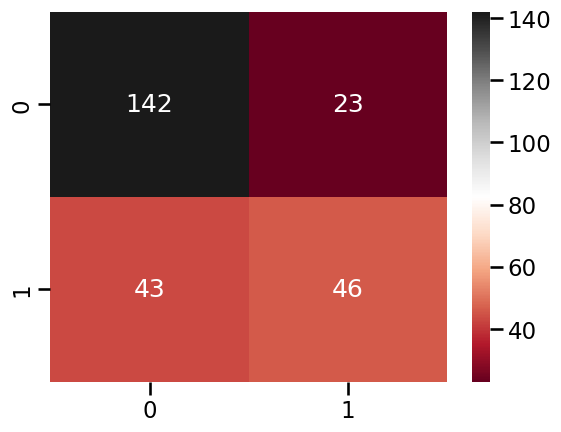

In [33]:
X_train_best = X_train_best.rename(columns = {0: 'Pregnancies', 1: 'Glucose', 2: 'Insulin', 3: 'BMI', 4: 'DPF', 5: 'Age'})
X_test_best = X_test_best.rename(columns = {0: 'Pregnancies', 1: 'Glucose', 2: 'Insulin', 3: 'BMI', 4: 'DPF', 5: 'Age'})

#Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss',                                                           
                               )

#Fit the classifier to the raw data
xgb_classifier.fit(X_train_best, y_res)

# predict the performance score of the trained model using the testing dataset
print_classification_metrics(xgb_classifier, X_train_best, y_res, X_test_best, y_test)

In [34]:
from sklearn.model_selection import StratifiedKFold

# Create a StratifiedKFold object
# skf = StratifiedKFold(n_splits=5,
#                       shuffle=True,
#                       random_state=21)

def strat_objective(trial):    
    # Define the hyperparameter search space
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.0, 5e-1, log=False)
    max_leaves = trial.suggest_int('max_leaves', 0, 64)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)    
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 100, log=False)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 100, log=False)
    eval_metric = trial.suggest_categorical("eval_metric", ['logloss',"error", "aucpr", 'error@0.6'])
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 1.870)  

    # Create the XGBClassifier with the sampled hyperparameters
    classifier = XGBClassifier(
        max_depth = max_depth,
        n_estimators = n_estimators,
        learning_rate = learning_rate,
        max_leaves = max_leaves,
        min_child_weight=min_child_weight,        
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        scale_pos_weight = scale_pos_weight,
        eval_metric = eval_metric,
        objective = 'binary:logistic',        
        grow_policy = 'lossguide',        
        use_label_encoder = False,
        seed = 21,
        n_jobs = -1,        
    )
    
    scores = cross_val_score(classifier, 
                             X_train_best, 
                             y_res,
                             cv=5,
                             scoring='average_precision',
                             verbose = False, n_jobs=-1)
    #return -scores.mean()
    return scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(strat_objective, n_trials=100, timeout = 600, show_progress_bar = True)

# Print the best hyperparameters and the corresponding score
print()
print('Best hyperparameters: ', pd.DataFrame([study.best_params]).transpose())
print()
print('Best score (Minimum loss): ', study.best_value)
print()

[I 2024-05-10 12:47:24,080] A new study created in memory with name: no-name-849cb2d0-13cf-4cb1-8540-9282735ca7b5


  0%|          | 0/100 [00:00<?, ?it/s]


Best hyperparameters:                            0
max_depth                 4
n_estimators            426
learning_rate      0.462626
max_leaves               33
min_child_weight          1
subsample          0.560388
colsample_bytree   0.616478
reg_alpha          3.471244
reg_lambda        41.222131
eval_metric       error@0.6
scale_pos_weight   1.672646

Best score (Minimum loss):  0.8583989365929998



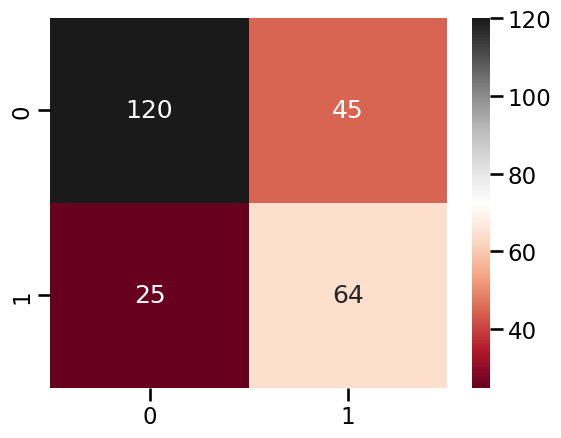

In [35]:
best_params = study.best_params

xgb_classifier_opt = XGBClassifier(**best_params,
                                   objective = 'binary:logistic',
                                   grow_policy = 'lossguide',
                                   use_label_encoder = False,
                                   seed = 21,
                                   n_jobs = -1).fit(X_train_best, y_res, verbose = 0)

print_classification_metrics(xgb_classifier_opt, X_train_best, y_res, X_test_best, y_test)

# Optimize an XGBoost classifier using hyperopt

In [36]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

# Define the hyperparameter search space
space = {
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
    'max_leaves': hp.choice('max_leaves', np.arange(10, 65, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),    
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 1e-8, 1.0),
}

# Define the objective function to optimize
def objective(params):
    classifier = XGBClassifier(
        max_depth = int(params['max_depth']),
        n_estimators = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        max_leaves = int(params['max_leaves']),
        min_child_weight = int(params['min_child_weight']),        
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda'],
        objective = 'binary:logistic',        
        use_label_encoder = False,
        seed = 21,
        n_jobs = -1,
    )

    score = cross_val_score(classifier, X_train_best, y_res, cv=5, scoring='neg_log_loss', n_jobs=-1)
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best]).transpose())
print()
print("Best score (Minimum loss):", trials.best_trial['result']['loss'])

100%|███████| 100/100 [00:44<00:00,  2.26trial/s, best loss: 0.4506469974830791]

Best hyperparameters:                            0
colsample_bytree    0.785023
learning_rate       0.008773
max_depth          10.000000
max_leaves         31.000000
min_child_weight    1.000000
n_estimators      540.000000
reg_alpha           0.418885
reg_lambda          0.592475
subsample           0.537759

Best score (Minimum loss): 0.4506469974830791


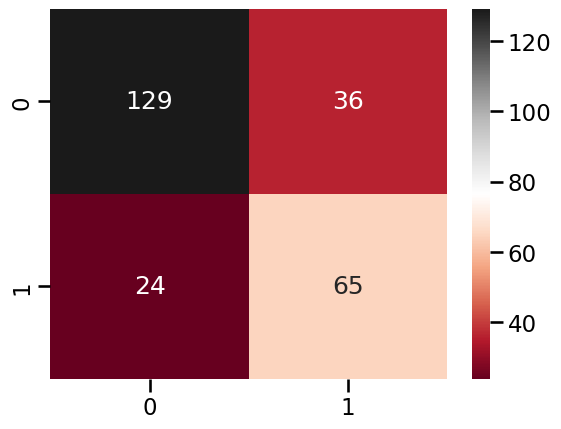

In [37]:
# Retrieve the best hyperparameters
best_params = trials.best_trial['misc']['vals']

# Extract scalar values from the lists
max_depth = int(best_params['max_depth'][0])
n_estimators = int(best_params['n_estimators'][0])
learning_rate = best_params['learning_rate'][0]
min_child_weight = int(best_params['min_child_weight'][0])
max_leaves = best_params['max_leaves'][0]
colsample_bytree = best_params['colsample_bytree'][0]
subsample = best_params['subsample'][0]
reg_alpha = best_params['reg_alpha'][0]
reg_lambda = best_params['reg_lambda'][0]

xgb_classifier_hyp = XGBClassifier(objective = 'binary:logistic',                                     
                                   learning_rate = learning_rate,
                                   max_depth = max_depth,
                                   max_leaves = max_leaves,
                                   n_estimators = n_estimators,                
                                   min_child_weight = min_child_weight,
                                   subsample = subsample,
                                   colsample_bytree = colsample_bytree,
                                   reg_alpha = reg_alpha,
                                   reg_lambda = reg_lambda,                                 
                                   scale_pos_weight = 1.853,
                                   use_label_encoder = False,
                                   seed = 21).fit(X_train_best, y_res, verbose = 0)

print_classification_metrics(xgb_classifier_hyp, X_train_best, y_res, X_test_best, y_test)

# Optimize a LightGBM model using optuna

In [38]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score

# LightGBM with Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# Define the objective function for LightGBM
def lgb_objective(trial):
    params = {        
        'objective': 'binary',        
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 64),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=False),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 11),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=False),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=False),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 21,
        #'n_jobs': -1, 
        'verbosity': -1,
    }

    scores = cross_val_score(lgb.LGBMClassifier(**params), 
                             X_train_best, y_res, 
                             cv=skf, 
                             scoring='neg_log_loss', 
                             #n_jobs=-1
                            )
    return -scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(lgb_objective, 
               n_trials=100, 
               timeout = 600, 
               show_progress_bar = True)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([study.best_params]).transpose())
print()
print("Best score (Minimum loss):", study.best_value)
print()

  0%|          | 0/100 [00:00<?, ?it/s]


Best hyperparameters:                             0
max_depth            7.000000
num_leaves          61.000000
n_estimators       349.000000
learning_rate        0.016522
min_child_weight     1.000000
min_child_samples    5.000000
reg_alpha            0.956199
reg_lambda           0.723670
colsample_bytree     0.640198
subsample            0.759338

Best score (Minimum loss): 0.4535137084064841



# Train and test a LightGBM model using optimized hyperparameters

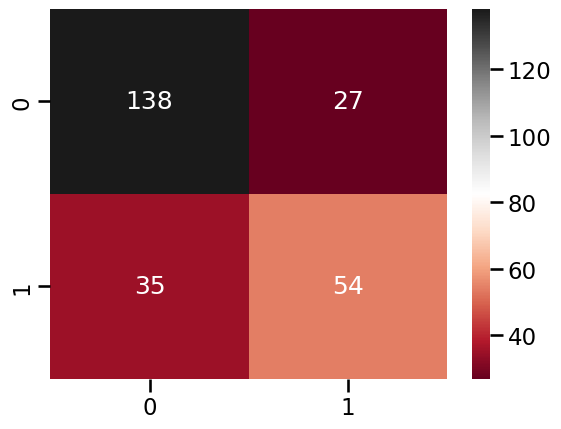

In [39]:
# Train the LightGBM model with the best hyperparameters
best_params = study.best_params
lgb_model = lgb.LGBMClassifier(**best_params, verbosity = -1)
lgb_model.fit(X_train_best, y_res)

print_classification_metrics(lgb_model, X_train_best, y_res, X_test_best, y_test)

In [40]:
import lightgbm as lgb
import warnings
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score
import sklearn

# LightGBM with Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# Define the hyperparameter search space
space = {        
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype = int)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)),
    'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, dtype = int)),
    'num_leaves': hp.choice('num_leaves', np.arange(10, 65, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'min_child_samples': hp.choice('min_child_samples', np.arange(5, 101, dtype = int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 1e-8, 1.0),
}

# Define the objective function to optimize
def objective(params):    
    classifier = lgb.LGBMClassifier(        
        objective = 'binary',
        max_depth = int(params['max_depth']),
        n_estimators = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        min_child_weight = int(params['min_child_weight']),        
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda'],
        is_unbalance = True,                
        seed = 21,
        #n_jobs = -1,
        verbosity = -1,
    )
    
    score = cross_val_score(classifier, 
                            X_train_best, y_res, 
                            cv=skf, 
                            scoring='neg_log_loss', 
                            #n_jobs=-1
                           )
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best]).transpose())
print()
print("Best score (Minimum loss):", trials.best_trial['result']['loss'])

100%|██████| 100/100 [03:51<00:00,  2.32s/trial, best loss: 0.45834686444139255]

Best hyperparameters:                             0
colsample_bytree     0.773041
learning_rate        0.013978
max_depth            6.000000
min_child_samples   53.000000
min_child_weight     1.000000
n_estimators       535.000000
num_leaves          53.000000
reg_alpha            0.858944
reg_lambda           0.652613
subsample            0.579415

Best score (Minimum loss): 0.45834686444139255


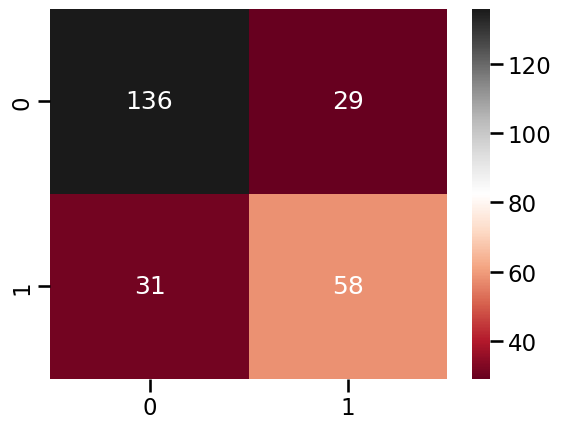

In [41]:
# Retrieve the best hyperparameters
best_params = trials.best_trial['misc']['vals']

# Extract scalar values from the lists
max_depth = int(best_params['max_depth'][0])
n_estimators = int(best_params['n_estimators'][0])
learning_rate = best_params['learning_rate'][0]
min_child_weight = int(best_params['min_child_weight'][0])
min_child_samples = int(best_params['min_child_samples'][0])
num_leaves = int(best_params['num_leaves'][0]) 
colsample_bytree = best_params['colsample_bytree'][0]
subsample = best_params['subsample'][0]
reg_alpha = best_params['reg_alpha'][0]
reg_lambda = best_params['reg_lambda'][0]


lgb_classifier_hyp = lgb.LGBMClassifier(objective = 'binary',
                                        max_depth = max_depth,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        min_child_weight = min_child_weight,
                                        min_child_samples = min_child_samples,
                                        num_eaves = num_leaves,
                                        colsample_bytree = colsample_bytree,
                                        subsample = subsample,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,                    
                                        is_unbalance = True,                                      
                                        seed=21,
                                        n_jobs=-1, 
                                        verbosity = -1).fit(X_train_best, y_res)
        
print_classification_metrics(lgb_classifier_hyp, X_train_best, y_res, X_test_best, y_test)

In [42]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
import optuna
import catboost
from optuna_integration import CatBoostPruningCallback


# Consider StratifiedShuffleSplit for imbalanced classes
skf = StratifiedShuffleSplit(n_splits=5, random_state=21)

# Define the objective function with early stopping
def catboost_objective(trial):
    params = {
        'objective': 'Logloss',  
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'depth': trial.suggest_int('max_depth', 2, 10), 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=False),        
        'num_leaves': trial.suggest_int('num_leaves', 10, 64),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=False),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'random_strength': trial.suggest_int('random_strength', 1, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0, log=False),
        'random_seed': 21,
        'grow_policy': 'Lossguide',
        'boosting_type': 'Plain',
        'used_ram_limit': '4gb',        
        'silent':True,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.852, 1.870)        
    }

    scores = cross_val_score(CatBoostClassifier(**params), 
                             X_train_best, y_res, 
                             cv=skf, scoring='neg_log_loss', 
                             n_jobs=-1)
    return -scores.mean()

    

# Create an Optuna study
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(catboost_objective, 
               n_trials=100, 
               timeout=600, 
               show_progress_bar = True)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([study.best_params]).transpose())
print()
print("Best score (Minimum loss):", study.best_value)
print()

  0%|          | 0/100 [00:00<?, ?it/s]

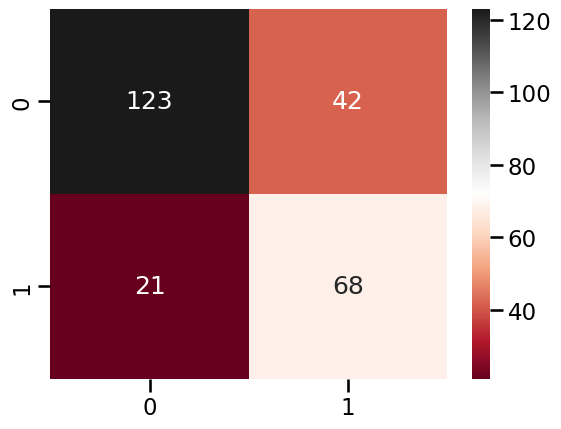

In [44]:
# Train the CatBoost model with the best hyperparameters
best_params = study.best_params
catboost_model = CatBoostClassifier(**best_params,
                                    objective = 'Logloss',
                                    grow_policy = 'Lossguide',
                                    silent = True,
                                    boosting_type = 'Plain',
                                    random_seed = 21,                                    
)

catboost_model.fit(X_train_best, y_res)

print_classification_metrics(catboost_model, X_train_best, y_res, X_test_best, y_test)

In [48]:
from catboost import CatBoostClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
import numpy as np
import sklearn

# Consider StratifiedShuffleSplit for imbalanced classes
skf = StratifiedShuffleSplit(n_splits=5, random_state=21)

# Define the hyperparameter search space
space = {
    'depth': hp.quniform('depth', 2, 10, 1), 
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)),
    'learning_rate': hp.uniform('learning_rate', 0.0, 1.0),
    'max_leaves': hp.uniform('max_leaves', 10, 64),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 100),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'min_data_in_leaf': hp.uniform("min_data_in_leaf", 5, 100), 
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'random_strength': hp.quniform('random_strength', 1, 100, 1),
    }

# Define the objective function with early stopping
def catboost_objective(params):
    classifier = CatBoostClassifier(        
        objective = 'Logloss',        
        depth = int(params['depth']),
        iterations = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        max_leaves = int(params['max_leaves']),
        l2_leaf_reg = params['l2_leaf_reg'],
        colsample_bylevel = params['colsample_bylevel'],
        min_data_in_leaf = params['min_data_in_leaf'],
        subsample = params['subsample'],
        random_strength = int(params['random_strength']),        
        random_state = 21,
        grow_policy = 'Lossguide',
        boosting_type = 'Plain',
        silent = True,
#thread_count = -1,  # Enable GPU if available

    )

    score = cross_val_score(classifier, 
                            X_train_best, y_res, 
                            cv=skf, 
                            scoring='neg_log_loss', 
                            #n_jobs=-1
                           )
    
    return {'loss': -score.mean(), 'status': STATUS_OK}
    
# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=catboost_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best]).transpose())
print()
print("Best score:", trials.best_trial['result']['loss'])

100%|███████| 100/100 [06:38<00:00,  3.98s/trial, best loss: 0.4379550700141988]

Best hyperparameters:                             0
colsample_bylevel    0.730266
depth                9.000000
l2_leaf_reg         38.225733
learning_rate        0.028242
max_leaves          59.223823
min_data_in_leaf    57.878569
n_estimators       348.000000
random_strength     37.000000
subsample            0.686031

Best score: 0.4379550700141988


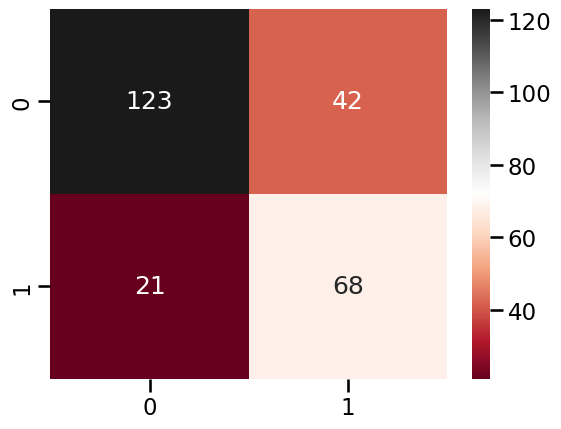

In [49]:
# Retrieve the best hyperparameters
best_params = trials.best_trial['misc']['vals']

# Extract scalar values from the lists
colsample_bylevel = best_params['colsample_bylevel'][0]
depth = int(best_params['depth'][0])
learning_rate = best_params['learning_rate'][0]
max_leaves = int(best_params['max_leaves'][0])
min_data_in_leaf = int(best_params['min_data_in_leaf'][0])
l2_leaf_reg = best_params['l2_leaf_reg'][0]
n_estimators = best_params['n_estimators'][0]
random_strength = int(best_params['random_strength'][0])
subsample = best_params['subsample'][0]


# Create a new CatBoostClassifier instance with the best hyperparameters
best_model = CatBoostClassifier(
    objective='Logloss',
    colsample_bylevel=colsample_bylevel,
    depth=depth,
    learning_rate=learning_rate,
    max_leaves = max_leaves,
    min_data_in_leaf = min_data_in_leaf,
    l2_leaf_reg=l2_leaf_reg,
    n_estimators = n_estimators,    
    random_strength=random_strength,
    subsample=subsample,
    random_state=21,
    grow_policy = 'Lossguide',
    boosting_type = 'Plain',
    silent = True,
    #thread_count=-1,    
)

# Train the best model on the resampled data
best_model.fit(X_train_best, y_res)

print_classification_metrics(catboost_model, X_train_best, y_res, X_test_best, y_test)